# CSE 4238 - Soft Computing Lab Project

# Implementing OnkoGan: Bangla Handwritten Digit Generation with Deep Convolutional Generative Adversarial Networks

*With eager execution enabled, TensorFlow functions execute operations immediately (as opposed to adding to a graph to be executed later in a tf. compat. v1. Session ) and return concrete values (as opposed to symbolic references to a node in a computational graph).*

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ayverkuv
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ayverkuv


In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pandas as pd
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Abrar drive path for ekush dataset
data_female = pd.read_csv('/content/drive/MyDrive/SongkhaGAN_dataset/Ekush/ekush_femaleDigits.csv')
data_male = pd.read_csv('/content/drive/MyDrive/SongkhaGAN_dataset/Ekush/ekush_maleDigits.csv')

In [ ]:
data = data_female
data = data.append(data_male, ignore_index=True)

In [ ]:
# Abrar drive path for banglalekhaisolated dataset 
data = np.load('/content/drive/MyDrive/SongkhaGAN_dataset/BanglaLekhaIsolated/Baish.npy')

In [ ]:
train_images = data.reshape(-1, 28, 28, 1)

In [ ]:
IMAGE_SHAPE = train_images.shape[1]
train_images = train_images.reshape(train_images.shape[0], IMAGE_SHAPE, IMAGE_SHAPE, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BATCH_SIZE = 32
BUFFER_SIZE = train_images.shape[0]

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [ ]:
# GENERATOR (Using Sepc. Norm.) 
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add( tfa.layers.SpectralNormalization( layers.Dense(32*32, input_shape=(100,)) ) ) #100 * 1024
    model.add( layers.BatchNormalization() )
    model.add( layers.Activation(activation='relu') )

    model.add( tfa.layers.SpectralNormalization( layers.Dense(7*7*128, input_shape=(100,)) ) ) #1024 * 6272
    model.add( layers.BatchNormalization() )
    model.add( layers.Activation(activation='relu') )
    
    model.add( layers.Reshape((7, 7, 128)) )  # 7, 7, 128

    model.add( tf.keras.layers.UpSampling2D( size=(2, 2)) ) # 14, 14, 128
    model.add( tfa.layers.SpectralNormalization( layers.Conv2D(64, (2,2), strides=(1,1), padding='same') ) )  # 14, 14, 64
    model.add( layers.BatchNormalization() )  # 14, 14, 64
    model.add( layers.Activation(activation='relu') ) # 14, 14, 64

    model.add(  tf.keras.layers.UpSampling2D( size=(2, 2))  )   # 28, 28, 64
    model.add( layers.Conv2D(1, (2,2), strides=(1,1), padding='same')  )  # 28, 28, 1
    model.add( layers.Activation(activation='tanh') )

    return model

Gnerated image shape: (1, 28, 28, 1)


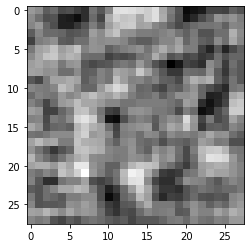

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print('Gnerated image shape:', generated_image.shape)

plt.imshow( ((generated_image[0, :, :, 0].numpy()*127.5)+127.5).astype('uint8'), cmap='gray' )


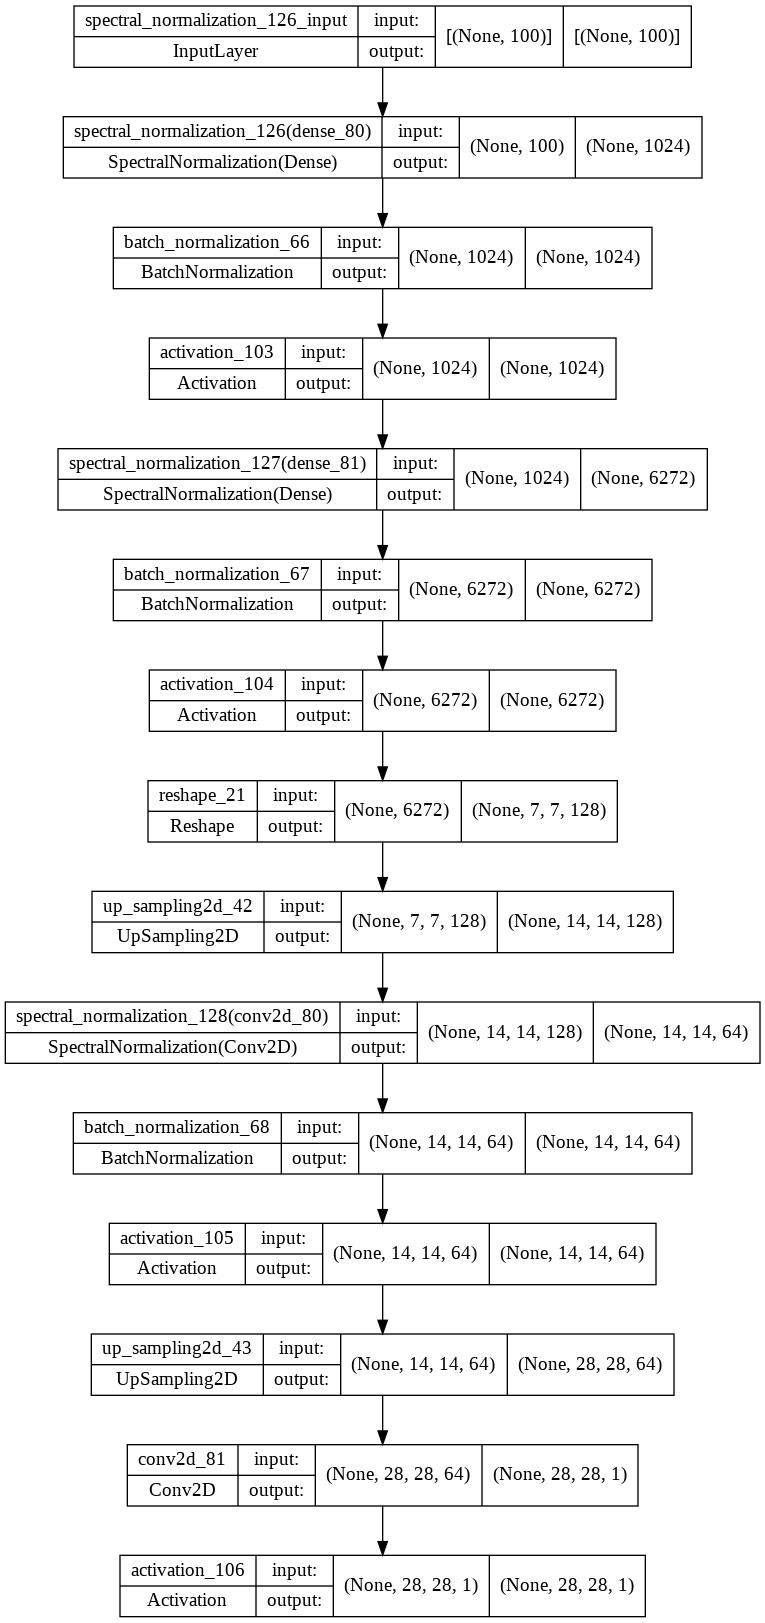

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(generator, to_file='model_plot_gan.png', show_shapes=True, show_layer_names=True)

In [ ]:
# DISCRIMINATOR (Using Sepc. Norm.) 
def make_discriminator_model():
    model = tf.keras.Sequential()                                                                 #2
    model.add( tfa.layers.SpectralNormalization(  layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SHAPE, IMAGE_SHAPE, 1]) ) )  14,14,64
    model.add(layers.LeakyReLU(0.2))

    model.add( tfa.layers.SpectralNormalization(  layers.Conv2D(128, (5, 5), strides=(3, 3), padding='same') ) )  5,5,128
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten()) #3200

    model.add( tfa.layers.SpectralNormalization(  layers.Dense(256) ) ) #256
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))

    model.add( layers.Dense(1) )  #1
    model.add(layers.Activation(activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5016984]], shape=(1, 1), dtype=float32)


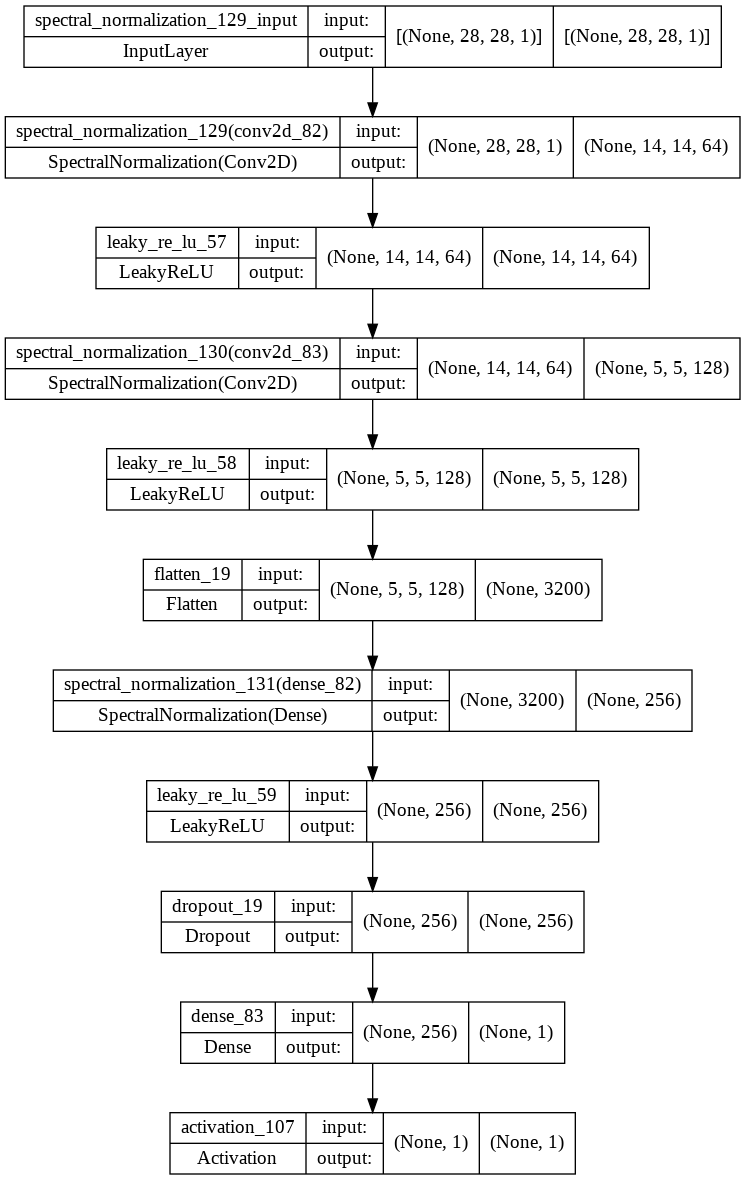

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(discriminator, to_file='model_plot_gan.png', show_shapes=True, show_layer_names=True)

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #Generator(Z) -> fake_output -> Discriminator() -> prediction
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
print(train_images[0].shape)
print(tf.ones_like(train_images[0]).shape)

(28, 28, 1)
(28, 28, 1)


In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.1)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.1)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 32

seed = tf.random.normal([num_examples_to_generate, noise_dim]) #32x100 [-1, 1]

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) 

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) 

      real_output = discriminator(images, training=True) #image
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss)

In [ ]:
gen_iteration_loss = []
gen_epoch_loss = []
dis_iteration_loss = []
dis_epoch_loss = []

def train(dataset, epochs):
  for epoch in range(epochs): #964 per epoch
    start = time.time()

    g_epoch_loss = []
    d_epoch_loss = []

    for image_batch in dataset: #1 batch
      gloss, dloss = train_step(image_batch)
      gen_iteration_loss.append(gloss.numpy())
      dis_iteration_loss.append(dloss.numpy())
      
      g_epoch_loss.append(gloss.numpy())
      d_epoch_loss.append(dloss.numpy())

    gen_epoch_loss.append( sum(g_epoch_loss)/np.ceil((BUFFER_SIZE/BATCH_SIZE)) )
    dis_epoch_loss.append( sum(d_epoch_loss)/np.ceil((BUFFER_SIZE/BATCH_SIZE)) )

    # Produce images for the GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16, 16))

  for i in range(predictions.shape[0]):
      plt.subplot(8, 4, i+1)
      plt.imshow( (predictions[i, :, :, 0].numpy() * 127.5 + 127.5).astype('uint8'), cmap='gray' )
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

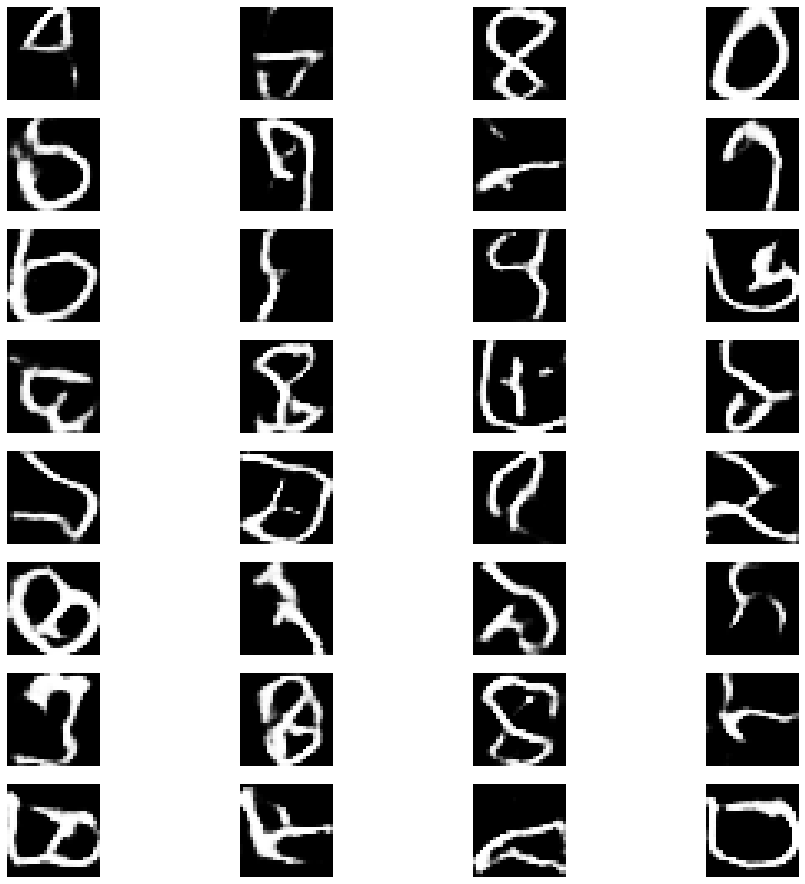

In [ ]:
train(train_dataset, epochs=EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Ekush - Results

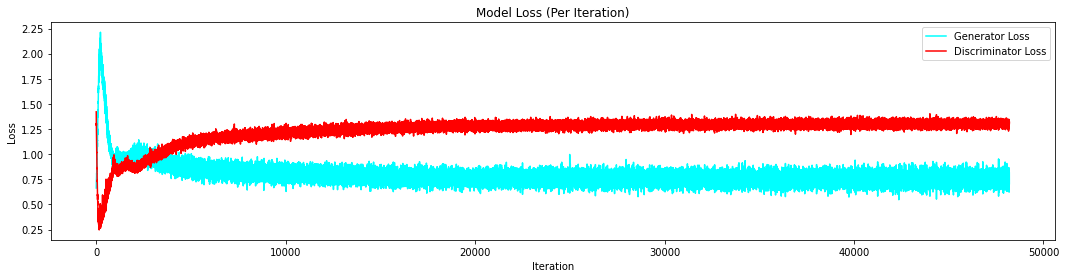

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(18,4))
plt.plot( np.arange(1, 48201), gen_iteration_loss, label='Generator Loss', color='cyan' )
plt.plot( np.arange(1, 48201), dis_iteration_loss, label='Discriminator Loss', color='red' )
plt.title('Model Loss (Per Iteration)')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(loc=0)
plt.savefig('GEN DIS LOSS vs Iteration (Ekush - Spectral).png', dpi=300)
plt.show()

In [ ]:
print(gen_epoch_loss[-1])
print(dis_epoch_loss[-1])
print(min(dis_epoch_loss))

0.7513889659860816
1.3011567763273153
0.5993719702872498


# Bangla Lekha Isolated - Results

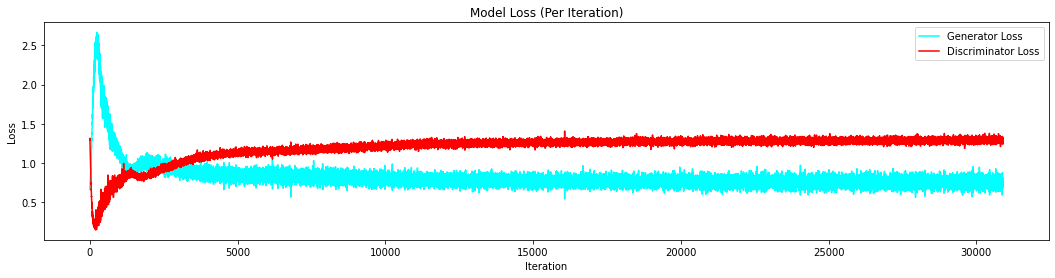

In [ ]:
plt.figure(figsize=(18,4))
plt.plot( np.arange(1, len(gen_iteration_loss)+1), gen_iteration_loss, label='Generator Loss', color='cyan' )
plt.plot( np.arange(1, len(dis_iteration_loss)+1), dis_iteration_loss, label='Discriminator Loss', color='red' )
plt.title('Model Loss (Per Iteration)')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(loc=0)
plt.savefig('GEN DIS LOSS vs Iteration (Bangla Lekha Isolated - Spectral).png', dpi=300)
plt.show()

In [ ]:
print(gen_epoch_loss[-1])
print(dis_epoch_loss[-1])
print(min(dis_epoch_loss))

0.7563668127777508
1.2896848265021363
0.44788515379706634
